In [439]:
from private.db.tianrun.spot.fdw.new_energy_actual_power import market_hourly_actual_power, market_name_dict
from private.db.tencnet.openmeteo.china_openmeteo_forecast3 import ProvinceForecastData

# from finance_utils.electrical2.spot.probabilistic.forecast.torch.transformer.vanilla2 import (
#     VanillaTransformer, vanilla_transformer_tester, vanilla_transformer_trainer, vanilla_transformer_trainer2)

from finance_utils.electrical2.spot.probabilistic.forecast.torch.transformer.vanilla_encoder import (
    VanillaTransformerEncoder, vanilla_transformer_tester, vanilla_transformer_trainer, vanilla_transformer_trainer2)

from private.db.tencnet.openmeteo.china_openmeteo_forecast3 import cma_new_energy_args, ecmwf_new_energy_args
from finance_utils.electrical2.spot.probabilistic.forecast.datasource.pfd_and_new_energy import torch_data_set as torch_data_set1
from finance_utils.electrical2.spot.probabilistic.forecast.datasource.pfd_and_new_energy2 import torch_data_set as torch_data_set2
from finance_utils.electrical2.spot.probabilistic.forecast.torch.normalization.basic import MinMax,ZScore,RobustScaler
import numpy
import pickle
import tqdm
from easy_datetime.timestamp import TimeStamp

import torch
from matplotlib import pyplot as plt
# from data_utils.serial_utils.series_trans_utils import MinMax, ZScore, RobustScaler, KmeansCluster

import os

import torch
from torch import nn

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor

In [440]:
root = r"E:\code\github\private\private\db\tencnet\openmeteo\data"

pfd = ProvinceForecastData("shanxi", "2024-10-1", "2024-10-31")
if os.path.exists(f"{root}\\china_ecmwf.pfd"):
    pass
else:
    pfd.add_new_energy_forecast("ecmwf")
    pfd.save(f"{root}\\china_ecmwf.pfd")


with open(f"{root}\\test_cma.pfd", "rb") as f:
    pfd:ProvinceForecastData = pickle.loads(f.read())
    
with open(f"{root}\\china_cma.pfd", "rb") as f:
    pfd2:ProvinceForecastData = pickle.loads(f.read())
    
with open(f"{root}\\test_ecmwf.pfd", "rb") as f:
    pfd3:ProvinceForecastData = pickle.loads(f.read())
    
with open(f"{root}\\china_ecmwf.pfd", "rb") as f:
    pfd4:ProvinceForecastData = pickle.loads(f.read())
    
print(pfd.stdt)
print(pfd.eddt)
# print(pfd.ecmwf_forecast_matrix[0])

2024-10-01 00:00:00
2024-10-31 23:59:59


In [441]:
x_norml_method = RobustScaler
y_norml_method = RobustScaler

fore_start = TimeStamp("2024-10-1")
fore_days = 19
fore_end = fore_start + ["day", fore_days]
x1,x_hat1,y1,y_hat1, yp1 = torch_data_set1(pfd, x_norml_method, y_norml_method, fore_start, fore_end, 
                                     ["cma", "evening", 1, 1],
                                     delete_column=[1], province_name="PHBSX",dims=cma_new_energy_args)

x2,x_hat2,y2,y_hat2, yp2 = torch_data_set2(pfd, x_norml_method, y_norml_method, fore_start, fore_end, 
                                     ["cma", "evening", 1, 1],
                                     delete_column=[1], province_name="PHBSX",dims=cma_new_energy_args)

x2b,x_hat2b,_,_, _ = torch_data_set2(pfd2, x_norml_method, y_norml_method, fore_start, fore_end, 
                                     ["cma", "evening", 1, 1],
                                     delete_column=[0, 1], province_name="PHBSX",dims=cma_new_energy_args)

x2c,x_hat2c,_,_, _ = torch_data_set2(pfd3, x_norml_method, y_norml_method, fore_start, fore_end, 
                                     ["ecmwf", "evening", 1, 1],
                                     delete_column=[0, 1], province_name="PHBSX",dims=ecmwf_new_energy_args)

x2d,x_hat2d,_,_, _ = torch_data_set2(pfd4, x_norml_method, y_norml_method, fore_start, fore_end, 
                                     ["ecmwf", "evening", 1, 1],
                                     delete_column=[0, 1], province_name="PHBSX",dims=ecmwf_new_energy_args)

# x,x_hat,y,y_hat,yp = x2,x_hat2,y2,y_hat2, yp2


100%|██████████| 2307/2307 [00:00<00:00, 107102.24it/s]


In [471]:
y,y_hat, yp = y2,y_hat2, yp2

x = torch.column_stack((x2[24:], x2c[24:], y[:len(y) - 24]))
x_hat = torch.column_stack((x_hat2[24:], x_hat2c[24:], y))

y = y[24:]
# y_hat = y_hat[24:]

# x = x2d
# x_hat = x_hat2d



# print(x2.shape)
# print(x2b.shape)
print(x.shape)
print(y.shape)
print(x_hat.shape)
print(y_hat.shape)
# print(yp.shape)
print(fore_start)
print(fore_end)

torch.Size([432, 1712])
torch.Size([432])
torch.Size([456, 1712])
torch.Size([480])
2024-10-01 00:00:00
2024-10-20 00:00:00


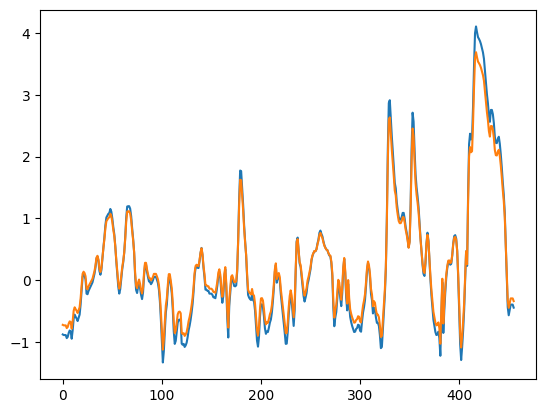

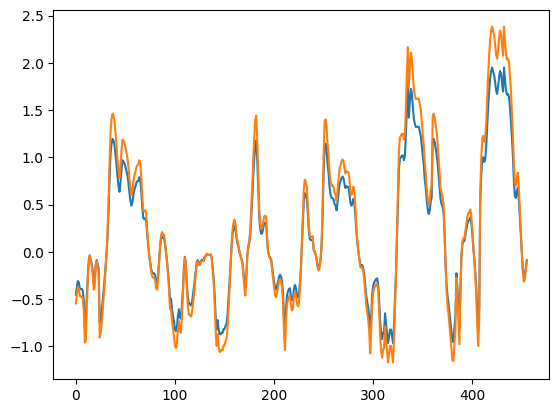

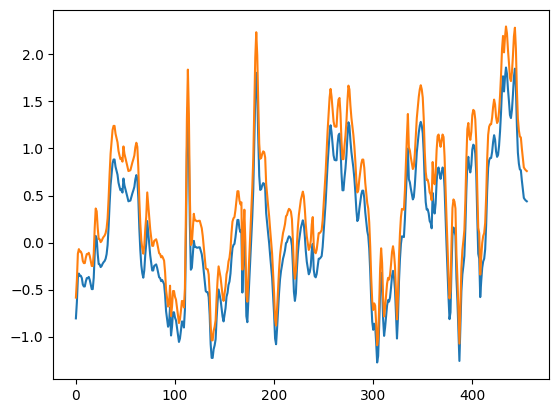

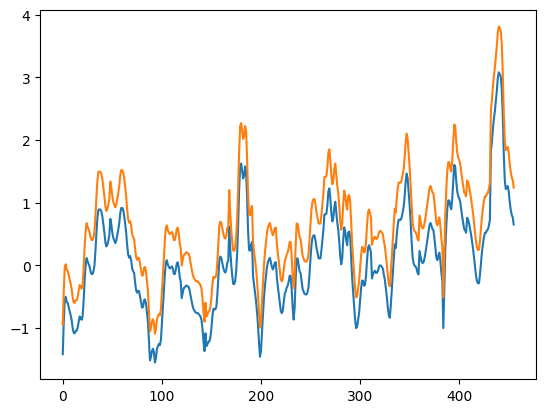

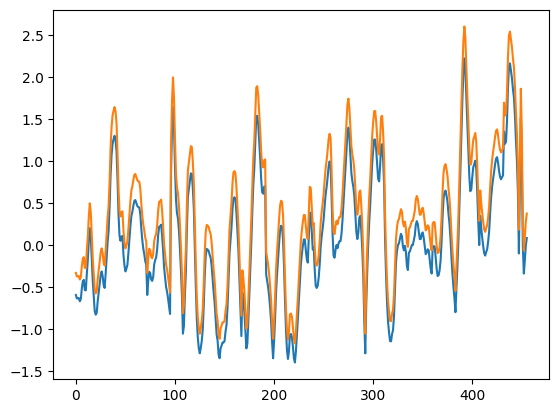

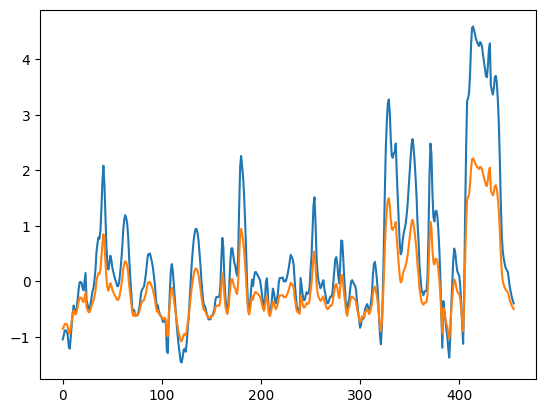

In [462]:
# plt.plot(x1[0])
# plt.plot(x2[0])
# plt.plot(x2b[0])
# plt.show()
for i in range(6, 12):
    # plt.subplot(1,2,1)
    plt.plot(x1[:,i])
    plt.plot(x2[:,i])
    # plt.plot(x2d[:,i])
    
    plt.show()
#     
# for i in range(6, 20 * 25, 25):
#     for j in range(1,5):
#         plt.subplot(1,4,j)
#         plt.plot(x2d[:,i])
#     plt.show()
    

In [465]:
input_size = x.shape[1]
d_model = 128
dim_feedforward = 1024
nhead = 4
output_size = 1
# num_layers = 4
num_layers = 8
# batch_size = fore_days * 4
batch_size = (fore_days - 1) * 4
# batch_size = 3
lr = 1e-3
use_y_tgt = False

model = VanillaTransformerEncoder(
    input_size=input_size,
    output_size=output_size,
    num_layers=num_layers,
    d_model=d_model,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    dropout=0.1
)

# model = VanillaTransformer(
#     input_size=input_size,
#     output_size=output_size,
#     num_encoder_layers=num_layers,
#     num_decoder_layers=num_layers,
#     d_model=d_model,
#     nhead=nhead,
#     dim_feedforward=dim_feedforward,
#     dropout=0.5
# )
print(model.cuda_device)

cpu


In [466]:
trained_model = vanilla_transformer_trainer2(model, x, y, batch_size, 100, lr=lr, loser=nn.L1Loss, shuffle=True)
# trained_model = vanilla_transformer_trainer2(model, x, y, batch_size, 100, lr=lr, L2=1e-5, loser=nn.L1Loss, shuffle=True, use_y_tgt=use_y_tgt)

100%|██████████| 100/100 [00:09<00:00, 10.78it/s]


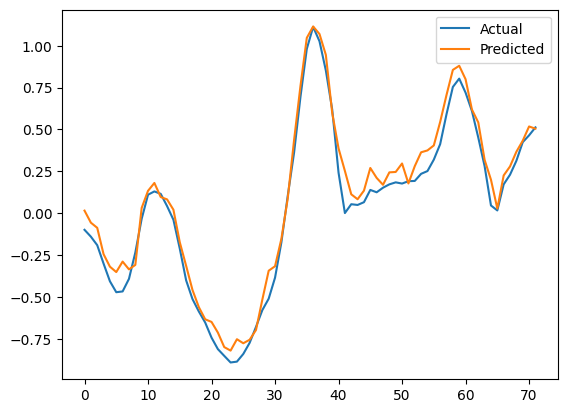

In [467]:
# p_train = vanilla_transformer_tester(trained_model, x, batch_size,use_y_tgt=use_y_tgt, train_y_tensor=y)
p_train = vanilla_transformer_tester(trained_model, x, batch_size)
# for b in range(batch_size):
#     plt.plot(y.reshape(-1,batch_size,1)[:,b], label='Actual')
#     plt.plot(p_train.cpu()[:,b], label='Predicted')
#     plt.legend()
#     plt.show()
    
plt.plot(y.reshape(-1)[len(y) - 24*3:], label='Actual')
plt.plot(p_train.cpu().view(-1)[len(y) - 24*3:], label='Predicted')
# plt.plot(p[:,1], label='Predicted')
plt.legend()
plt.show()

torch.Size([456, 1712])
torch.Size([456])
torch.Size([432, 1712])
torch.Size([432])
torch.Size([6, 72, 1])


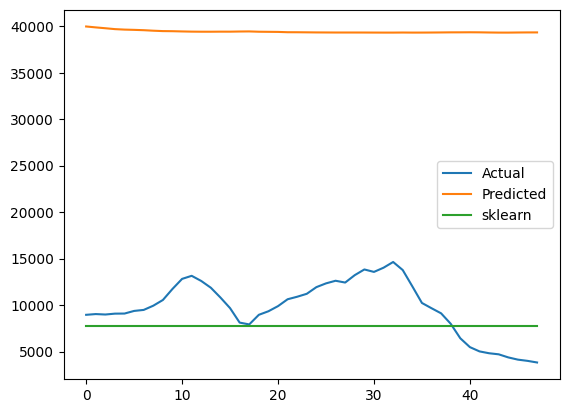

In [468]:
# his_days = fore_days - 1
print(x_hat.shape)
print(y_hat.shape)
# his_days = fore_days - 2
# test_st_days = 1
# x_hat_s = x_hat[(test_st_days * 24):]
# y_hat_s = y_hat[(test_st_days * 24):]
# 
# hat_days= len(x_hat) / 24
x_hat_s = x_hat[24:24+len(x)]
y_hat_s = y_hat[24:24+len(x)]

print(x_hat_s.shape)
print(y_hat_s.shape)


rfr = SVR()
rfr.fit(x.reshape(-1,input_size).numpy(),y.reshape(-1).numpy())
rfr_p = rfr.predict(x_hat_s.reshape(-1, input_size).numpy())

p_test = vanilla_transformer_tester(trained_model, x_hat_s, batch_size)
# p_test = vanilla_transformer_tester(trained_model, x_hat_s, batch_size, use_y_tgt=use_y_tgt, train_y_tensor=y)

print(p_test.shape)
# for b in range(batch_size):
#     p_b = p_test.cpu()[:,b]
#     re_normed_p_b = y_norml_method.invert(p_b, yp)
#     plt.plot(y_hat.reshape(-1,batch_size,1)[:,b], label='Actual')
#     plt.plot(re_normed_p_b, label='Predicted')
#     plt.legend()
#     plt.show()

show_days = 2
  

re_normed_p_test =  y_norml_method.invert(p_test.cpu().view(-1), yp)[len(y_hat_s) - 24 * show_days:]
re_normed_sklearn = y_norml_method.invert(rfr_p, yp)[len(y_hat_s) - 24 * show_days:]
plt.plot(y_hat_s.reshape(-1)[len(y_hat_s) - 24 * show_days:], label='Actual')
plt.plot(re_normed_p_test, label='Predicted')
plt.plot(re_normed_sklearn, label='sklearn')
# plt.plot(p[:,1], label='Predicted')
plt.legend()
plt.show()
# 
# print(y_hat.reshape(-1)[his_days*24:])
# print(re_normed_p_test)

100%|██████████| 24/24 [00:01<00:00, 13.06it/s]


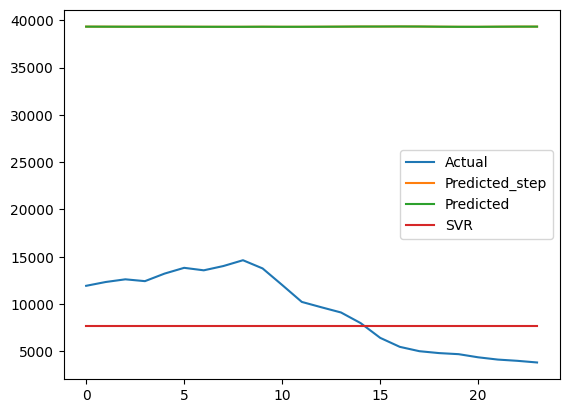

[39331.79  39326.96  39321.996 39322.156 39321.977 39320.06  39316.09
 39313.445 39313.324 39321.01  39313.766 39315.105 39320.957 39329.492
 39339.824 39341.652 39347.926 39341.87  39324.715 39313.715 39312.42
 39324.035 39332.152 39333.336]


In [469]:
step_by_step_model_p = []
for i in tqdm.trange(1,25):
    x_hat_step = x_hat[i:i+len(x)]
    y_hat_step = y_hat[i:i+len(x)]
    # p_step_test = vanilla_transformer_tester(trained_model, x_hat_step, batch_size, use_y_tgt=use_y_tgt, train_y_tensor=y)
    p_step_test = vanilla_transformer_tester(trained_model, x_hat_step, batch_size)
    
    
    step_by_step_model_p.append(p_step_test.view(-1)[-1]) 
un_norm_step_by_step_model_p = y_norml_method.invert(step_by_step_model_p, yp)

rfr_p = rfr.predict(x_hat_s.reshape(-1, input_size).numpy())
un_norm_svr = y_norml_method.invert(rfr_p, yp)[len(y_hat_s) - 24 * 1:]

plt.plot(y_hat_s.reshape(-1)[len(y_hat_s) - 24 * 1:], label='Actual')
plt.plot(un_norm_step_by_step_model_p, label='Predicted_step')
plt.plot(re_normed_p_test[24:], label='Predicted')
plt.plot(un_norm_svr, label='SVR')
plt.legend()
plt.show()
print(un_norm_step_by_step_model_p)